In [1]:
from glob import glob
import pandas as pd

def read_data(files):
    acc_set = 1
    gyr_set = 1

    acc_df = pd.DataFrame()
    gyr_df = pd.DataFrame()

    for f in files:
        participant = f.split("\\")[1].replace(f, "").split("-")[0]
        label = f.split("-")[1]
        category = f.split("-")[2].rstrip("123")

        df = pd.read_csv(f)

        df["participant"] = participant
        df["label"] = label
        df["category"] = category

        if "Accelerometer" in f:
            df["set"] = acc_set
            acc_set += 1
            acc_df = pd.concat([acc_df, df])

        if "Gyroscope" in f:
            df["set"] = gyr_set
            gyr_set += 1
            gyr_df = pd.concat([gyr_df, df])
            
    acc_df.index = pd.to_datetime(acc_df["epoch (ms)"], unit="ms")
    gyr_df.index = pd.to_datetime(gyr_df["epoch (ms)"], unit="ms")
    
    
    del acc_df["epoch (ms)"]
    del acc_df["time (01:00)"]
    del acc_df["elapsed (s)"]       
    del gyr_df["epoch (ms)"]
    del gyr_df["time (01:00)"]
    del gyr_df["elapsed (s)"]
    
    return acc_df, gyr_df

files = glob("../../data/raw/*.csv")

In [2]:
def process_data(files = files):
    acc_df, gyr_df = read_data(files)
    df_mergerd = pd.concat([acc_df.iloc[:,:3], gyr_df], axis=1)

    df_mergerd.columns = [
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z",
        "participant",
        "label",
        "category",
        "set"
    ]

    sampling_rules = {
        "acc_x": "mean",
        "acc_y": "mean",
        "acc_z": "mean",
        "gyr_x": "mean",
        "gyr_y": "mean",
        "gyr_z": "mean",
        "participant": "last",
        "label": "last",
        "category": "last",
        "set": "last"
    }

    days = [g for n, g in df_mergerd.groupby(pd.Grouper(freq="D"))]
    df_resampled = pd.concat([df.resample("150ms").apply(sampling_rules).dropna() for df in days])

    df_resampled["set"] = df_resampled["set"].astype("int")
    return df_resampled

In [3]:
def export_data(output_path):
    df_resampled = process_data()
    df_resampled.to_csv(output_path, index=False)

In [4]:
output_path = "../../data/partially processed/resampled_data.csv"
export_data(output_path)

In [17]:
df = pd.read_csv(output_path)


In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix

# Convert categorical data to numerical data
df_encoded = df.copy()
df_encoded['participant'] = df_encoded['participant'].astype('category').cat.codes
df_encoded['label'] = df_encoded['label'].astype('category').cat.codes
df_encoded['category'] = df_encoded['category'].astype('category').cat.codes

# Calculate the correlation matrix for the encoded dataframe
corr_matrix_encoded = df_encoded.corr()

# Plot the heatmap for the encoded correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_encoded, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Encoded)')
plt.show()

In [19]:
numeric_cols = df_encoded.select_dtypes(include=['float64']).columns
for col in numeric_cols:
    Q1 = df_encoded[col].quantile(0.05)
    Q3 = df_encoded[col].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_encoded = df_encoded[(df_encoded[col] >= lower_bound) & (df_encoded[col] <= upper_bound)]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare the data
X = df_encoded.drop(columns=['label'])
y = df_encoded['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
df_encoded.info()

In [ ]:
df_encoded['label'].unique()

In [ ]:
import pandas as pd
df = pd.read_csv("../../data/partially processed/resampled_data.csv")

In [ ]:
df['label'].unique()

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ...existing code...

# Load data from CSV
df = pd.read_csv("../../data/partially processed/resampled_data.csv")

# Select relevant columns
data = df[["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]]

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
labels = dbscan.fit_predict(scaled_data)

# Mark clusters and outliers
df["cluster"] = labels
outliers = df[df["cluster"] == -1]

# ...existing code...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# ...existing code...

# Load and prepare data
df = pd.read_csv("F:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv")
label_column = 'label'
numeric_data = df.select_dtypes(include=[np.number]).fillna(0)

# Scale numeric data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
labels = dbscan.fit_predict(scaled_data)

# Store cluster labels (-1 indicates outliers)
df['outlier'] = labels

# Plot by label, coloring points by outlier status
for label_val in df[label_column].unique():
    subset = df[df[label_column] == label_val]
    for col in numeric_data.columns:
        plt.figure(figsize=(10, 6))
        plt.scatter(subset.index, subset[col], c=subset['outlier'], cmap='coolwarm')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.title(f'Label: {label_val} - Outliers detected in {col}')
        plt.show()

# ...existing code...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ...existing code...

def chauvenet_outliers(values):
    mean_val = np.mean(values)
    std_val = np.std(values)
    N = len(values)
    z = np.abs((values - mean_val) / (std_val if std_val != 0 else 1e-10))
    prob_two_tailed = 2 * (1 - norm.cdf(z))
    return prob_two_tailed < (1.0 / (2 * N))

df = pd.read_csv("F:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv")
label_column = 'label'
numeric_data = df.select_dtypes(include=[np.number]).fillna(0)

for label_val in df[label_column].unique():
    subset = df[df[label_column] == label_val]
    for col in numeric_data.columns:
        outlier_mask = chauvenet_outliers(subset[col])
        c_vals = outlier_mask.map({True: 1, False: 0})  # color mapping
        plt.figure(figsize=(10, 6))
        plt.scatter(subset.index, subset[col], c=c_vals, cmap='coolwarm')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.title(f'Label: {label_val} - Outliers detected in {col} (Chauvenet)')
        plt.show()

# ...existing code...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def chauvenet_outliers(values, factor=1.0):
    mean_val = np.mean(values)
    std_val = np.std(values)
    N = len(values)
    z = np.abs((values - mean_val) / (std_val if std_val != 0 else 1e-10))
    prob_two_tailed = 2 * (1 - norm.cdf(z))
    # Adjust detection via factor (default = 1.0)
    return prob_two_tailed < (factor / (2 * N))

df = pd.read_csv("F:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv")
label_column = 'label'
factor = 1.2  # Adjust this for stricter or looser outlier detection

# Identify Chauvenet outliers
numeric_data_cols = df.select_dtypes(include=[np.number]).columns
df["outlier"] = False
for col in numeric_data_cols:
    outlier_mask = chauvenet_outliers(df[col], factor=factor)
    df.loc[outlier_mask, "outlier"] = True

# Drop outliers
df_no_outliers = df[~df["outlier"]]

# Optional: plotting
for label_val in df_no_outliers[label_column].unique():
    subset = df_no_outliers[df_no_outliers[label_column] == label_val]
    for col in numeric_data_cols:
        plt.figure(figsize=(10, 6))
        plt.scatter(subset.index, subset[col], c='blue', label='Data')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.title(f'Label: {label_val} - Chauvenet Filtered {col}')
        plt.legend()
        plt.show()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def chauvenet_outliers(values):
    mean_val = np.mean(values)
    std_val = np.std(values)
    N = len(values)
    z = np.abs((values - mean_val) / (std_val if std_val != 0 else 1e-10))
    prob_two_tailed = 2 * (1 - norm.cdf(z))
    return prob_two_tailed < (1.0 / (2 * N))

def detect_outliers(df):
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    df["outlier"] = False
    for col in columns_to_check:
        outlier_mask = chauvenet_outliers(df[col])
        df.loc[outlier_mask, "outlier"] = True
    return df

df = pd.read_csv("F:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv")

In [ ]:
detect_outliers(df)

In [1]:
def LOF_outliers(df, k=20):
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    features = df[columns_to_check]
    lof = LocalOutlierFactor(n_neighbors=k)
    outlier_labels = lof.fit_predict(features)
    lof_scores = lof.negative_outlier_factor_

    df['outlier_label'] = outlier_labels
    df['lof_score'] = lof_scores
    
    return df

In [2]:
def plot_outliers(df, columns_to_check):
    # Plot each feature against the outlier label
    for col in columns_to_check:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df.index, y=df[col], hue=df['outlier_label'], palette='coolwarm')
        plt.title(f'Outlier Detection in {col}')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.legend(title='Outlier Label')
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(file_path, columns_to_check, n_neighbors=10):
    # Load the dataset
    df = pd.read_csv(file_path)

    # Select specified columns and drop NaN values
    features = df[columns_to_check].dropna()

    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    outlier_labels = lof.fit_predict(features)
    lof_scores = lof.negative_outlier_factor_

    # Store results
    df['outlier_label'] = outlier_labels
    df['lof_score'] = lof_scores

    return df

def plot_outliers(df, columns_to_check):
    # Plot each feature against the outlier label
    for col in columns_to_check:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df.index, y=df[col], hue=df['outlier_label'], palette='coolwarm')
        plt.title(f'Outlier Detection in {col}')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.legend(title='Outlier Label')
        plt.show()

# Example usage
file_path = "f:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv"
columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
result_df = detect_outliers(file_path, columns_to_check)
result_df
# Plot the results
plot_outliers(result_df, columns_to_check)

In [9]:
file_path = "f:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv"
df = pd.read_csv(file_path)
df['category'].unique()
df['category'] = df['category'].str.replace(r'(_MetaWear_2019|\d+)', '', regex=True)
df['category'].unique()


array(['heavy', 'medium', 'sitting', 'standing'], dtype=object)

In [11]:
file_path = "f:/Studia/Inżynierka/inzynierka/data/partially processed/resampled_data.csv"
df = pd.read_csv(file_path)
df['category'].unique()

array(['heavy', 'medium', 'heavy_MetaWear_2019', 'heavy2_MetaWear_2019',
       'heavy1_MetaWear_2019', 'medium_MetaWear_2019',
       'sitting_MetaWear_2019', 'standing_MetaWear_2019'], dtype=object)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import LocalOutlierFactor
import seaborn as sns

def LOF_outliers(df, k=20):
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    features = df[columns_to_check]
    lof = LocalOutlierFactor(n_neighbors=k)
    outlier_labels = lof.fit_predict(features)
    # lof_scores = lof.negative_outlier_factor_

    df['outlier_label'] = outlier_labels
    
    return df

df = pd.read_csv("../../data/partially processed/resampled_data.csv")
df_no_outliers = df.copy()
columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
for col in columns_to_check:
    for label in df["label"].unique():
        data = LOF_outliers(df[df["label"] == label], col)
        
        data.loc[data[col + "_outlier"] == -1, col] = np.nan
        
        df_no_outliers.loc[df_no_outliers["label"] == label, col] = data[col]

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor

def LOF_outliers(df, k=20):
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    features = df[columns_to_check]
    
    lof = LocalOutlierFactor(n_neighbors=k)
    outlier_labels = lof.fit_predict(features)
    df['outlier_label'] = outlier_labels
    
    
    # Impute outliers by replacing them with the median of inlier values for each column
    for col in columns_to_check:
        df.loc[df['outlier_label'] == -1, col] = np.nan

    return df

In [ ]:

print(df.isnull().sum())

AttributeError: module 'matplotlib' has no attribute 'figure'

In [17]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

def LOF_outliers(df, k=20):
    columns_to_check = ["acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]
    features = df[columns_to_check]
    
    lof = LocalOutlierFactor(n_neighbors=k)
    outlier_labels = lof.fit_predict(features)
    df['outlier_label'] = outlier_labels
    # Plot each feature against the outlier label
    for col in columns_to_check:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=df.index, y=df[col], hue=df['outlier_label'], palette='coolwarm')
        plt.title(f'Outlier Detection in {col}')
        plt.xlabel('Index')
        plt.ylabel(col)
        plt.legend(title='Outlier Label')
        plt.show()

    return df

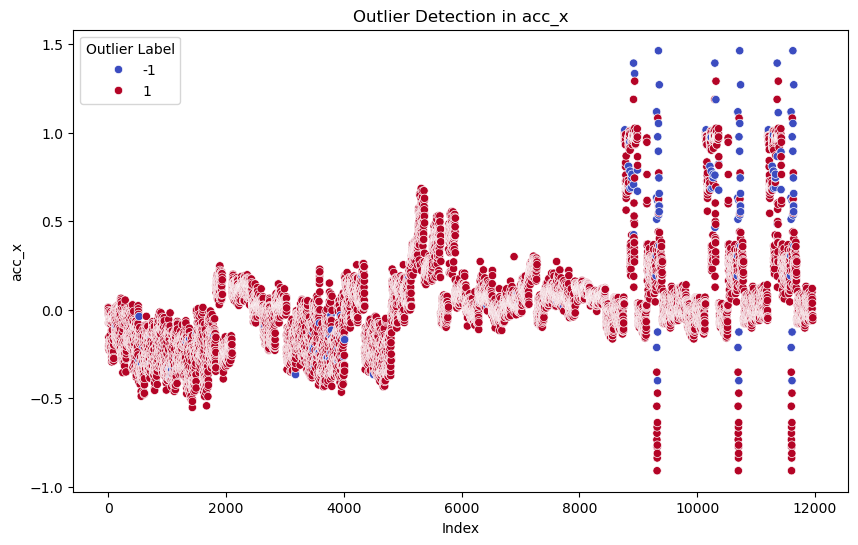

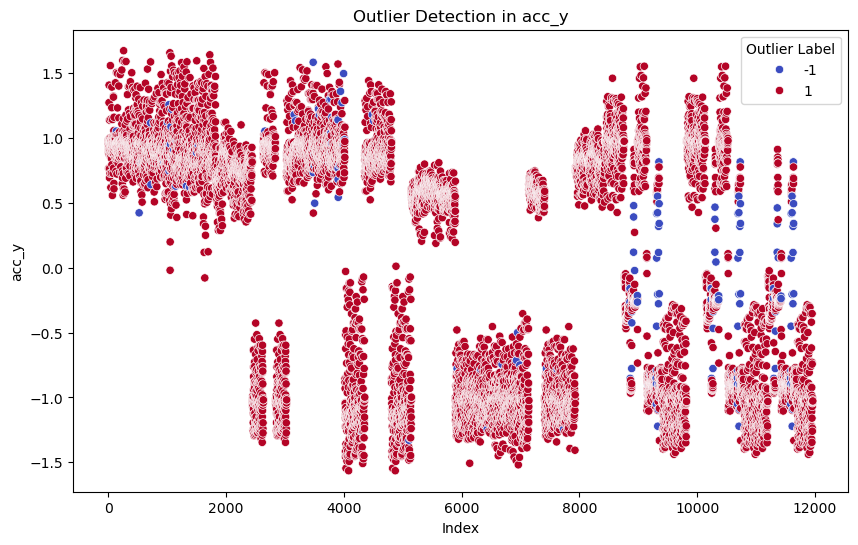

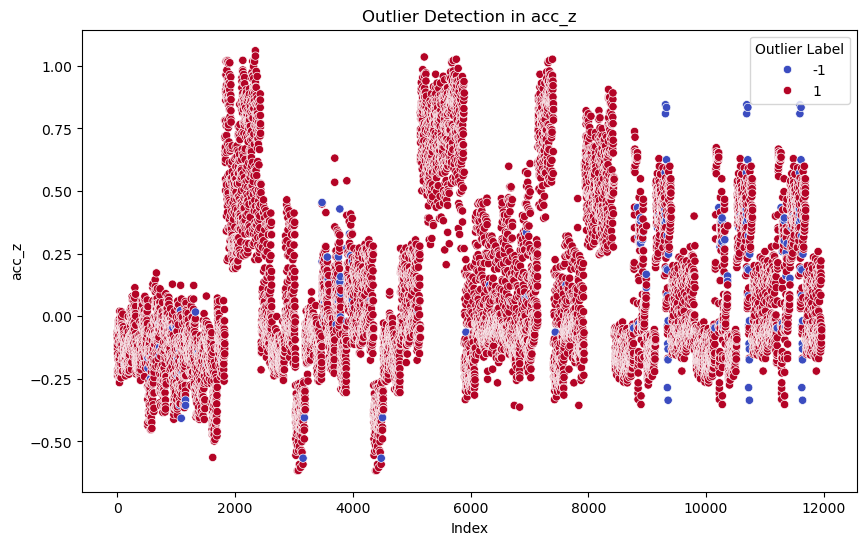

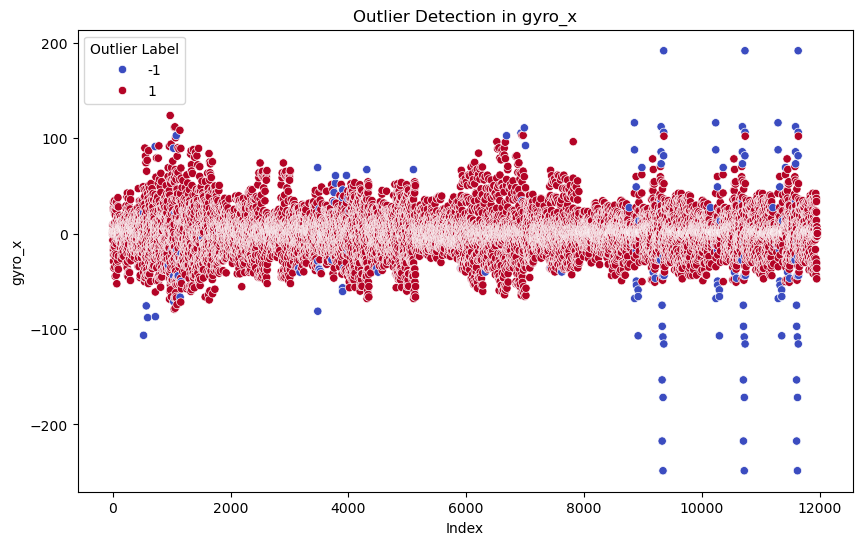

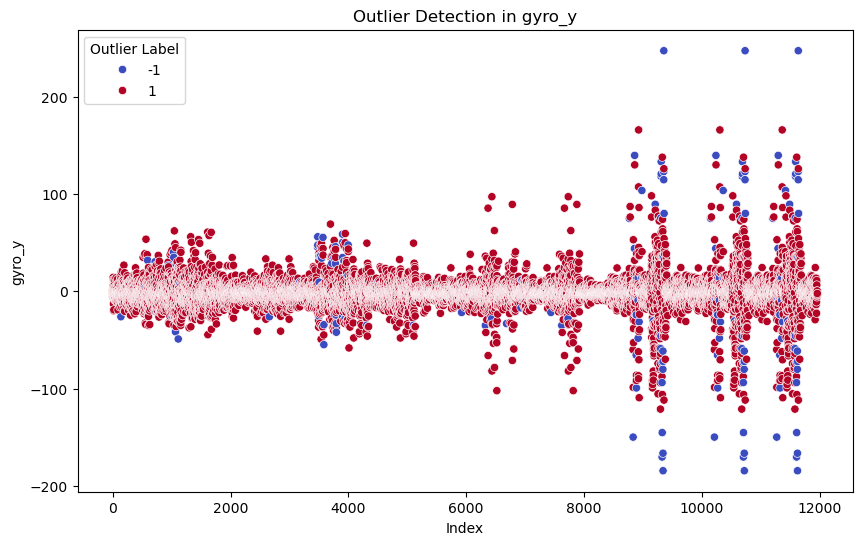

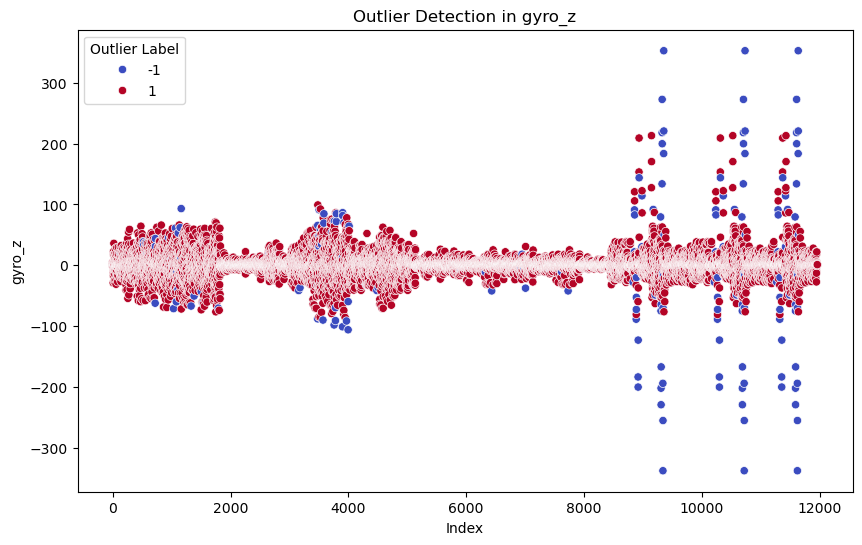

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,participant,label,category,set,outlier_label
0,0.0135,0.9770,-0.0710,-0.823250,0.335500,5.198000,B,bench,heavy,30,1
1,-0.0110,0.9700,-0.0860,0.813333,-2.236000,1.463333,B,bench,heavy,30,1
2,0.0100,0.9835,-0.0620,-7.012000,-0.823250,1.113000,B,bench,heavy,30,1
3,-0.0040,0.9595,-0.0710,9.451000,1.082500,-1.326250,B,bench,heavy,30,1
4,-0.0240,0.9570,-0.0735,8.125000,-5.670750,-2.530250,B,bench,heavy,30,1
...,...,...,...,...,...,...,...,...,...,...,...
11958,-0.0345,-1.0360,-0.0490,-2.789750,-1.737750,1.921000,E,row,medium,90,1
11959,-0.0420,-1.0190,-0.0620,0.015250,-4.146500,1.372000,E,row,medium,90,1
11960,-0.0600,-1.0310,-0.0820,3.516333,-3.394333,-0.488000,E,row,medium,90,1
11961,-0.0345,-1.0285,-0.0420,-0.061000,0.427000,1.112750,E,row,medium,90,1


In [18]:
df = pd.read_csv("../../data/partially processed/resampled_data.csv")
LOF_outliers(df)